In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image

In [3]:
# 创建空白画布
def InitCanvas(width, height, color=(255, 255, 255)):
    canvas = np.ones((height, width, 3), dtype="uint8")
    canvas[:] = color
    return canvas

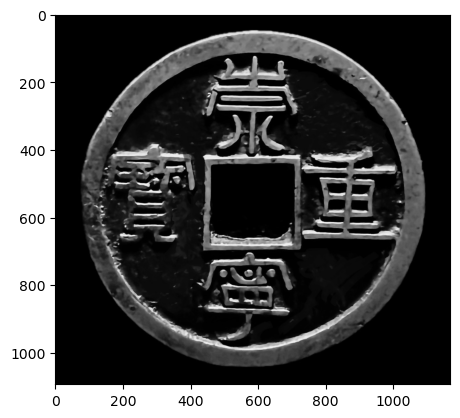

In [4]:
# 传入照片，灰度化
img = cv2.imread("./02.PNG")
img_back = cv2.imread("./022.PNG")# 背面
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray_back = cv2.cvtColor(img_back,cv2.COLOR_BGR2GRAY)
plt.imshow(gray,cmap="gray")

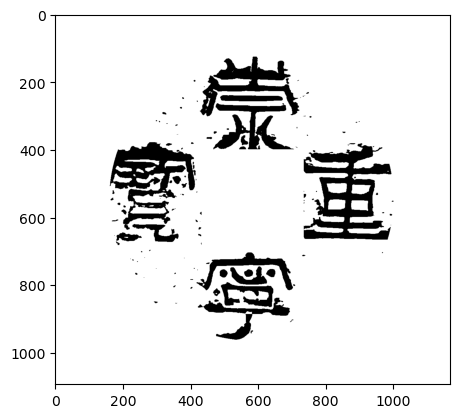

In [6]:
# 清除内郭
r0,black_img1 = cv2.threshold(gray,30,255,cv2.THRESH_BINARY_INV)
r2,black_img2 = cv2.threshold(gray_back,80,255,cv2.THRESH_BINARY_INV)
r1,black_img = cv2.threshold(gray,30,255,cv2.THRESH_BINARY_INV)
cv2.imwrite(os.path.join("./temp/", f'seg_temp1.jpg'), black_img1) # 保存拓片正面原始图片
cv2.imwrite(os.path.join("./temp/", f'seg_temp2.jpg'), black_img2) # 保存拓片正面原始图片
canvas = InitCanvas(1500, 1500, color=(255, 255, 255))
inter =canvas[400:700, 433:735]
inter = cv2.cvtColor(inter, cv2.COLOR_BGR2GRAY)
black_img[400:700,433:735]=inter

# 清除外郭
roi = np.zeros(black_img.shape[:2], np.uint8)
roi = cv2.circle(roi, (580, 545), 420, 255, cv2.FILLED)
mask = np.ones_like(black_img) * 255
mask = cv2.bitwise_and(mask, black_img, mask=roi) + cv2.bitwise_and(mask, mask, mask=~roi)
plt.imshow(mask,cmap="gray")
# plt.imshow(black_img1,cmap="gray")

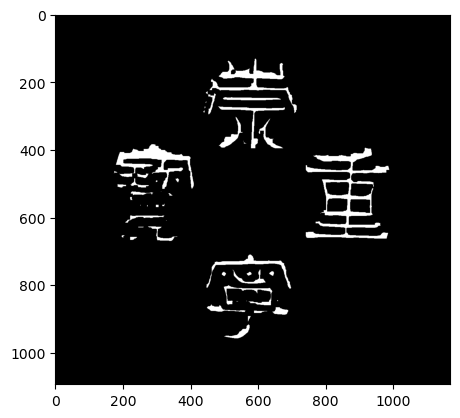

In [5]:
# 反转
r2,black_img1 = cv2.threshold(mask,40,255,cv2.THRESH_BINARY_INV)
# plt.imshow(black_img1,cmap="gray")

# 侵蚀，去除噪点
kernel = np.ones((4,4),dtype=np.int8)
erosion = cv2.erode(black_img1, kernel, iterations=3)
plt.imshow(erosion,cmap="gray")

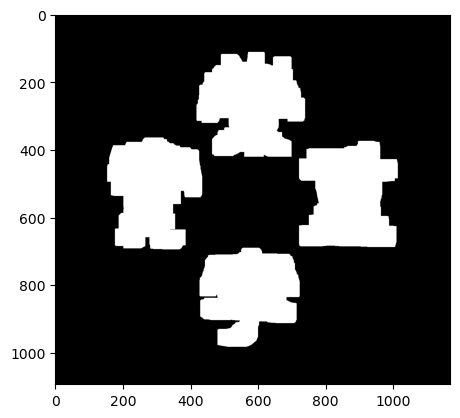

In [6]:
# 膨胀
kernel = np.ones((10,10),dtype=np.int8)
dilation = cv2.dilate(erosion, kernel, iterations=5)
plt.imshow(dilation,cmap="gray")

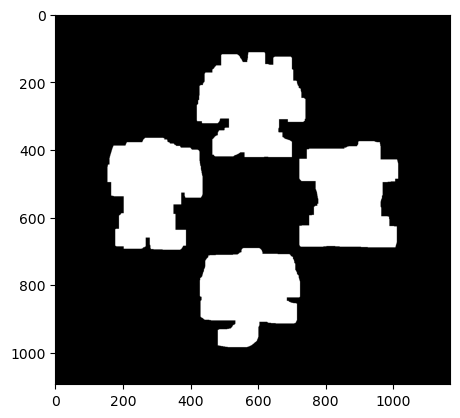

In [7]:
# 闭合
kernel = np.ones((10,10),dtype=np.int8)
closing = cv2.morphologyEx(dilation, cv2.MORPH_CLOSE, kernel)
plt.imshow(closing ,cmap="gray")

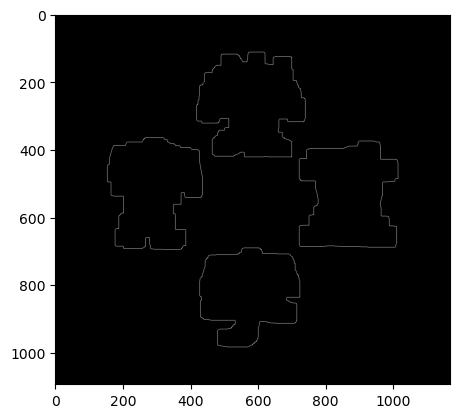

In [8]:
# 检测边缘
edges =cv2.Canny(closing,30,200)
plt.imshow(edges ,cmap="gray")

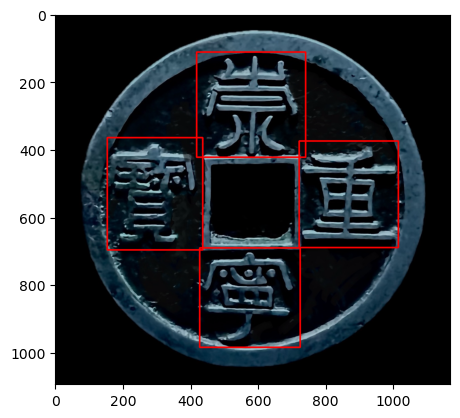

In [10]:
coutours,h = cv2.findContours(edges,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
img_copy = img.copy()
i=1
for c in coutours:
    x,y,w,h = cv2.boundingRect(c)
    if w > 70:
        img_seg = img[y:y+h,x:x+w]
        img_seg1 = black_img1[y:y+h,x:x+w]
        cv2.imwrite(os.path.join("./seg_pic/02/", f'seg_{i}.jpg'), img_seg)
        cv2.imwrite(os.path.join("./seg_pic_T/", f'seg_{i}.jpg'), img_seg1)
        cv2.rectangle(img_copy,(x,y),(x+w,y+h),(255,0,0),3)
        i+=1
plt.imshow(img_copy)

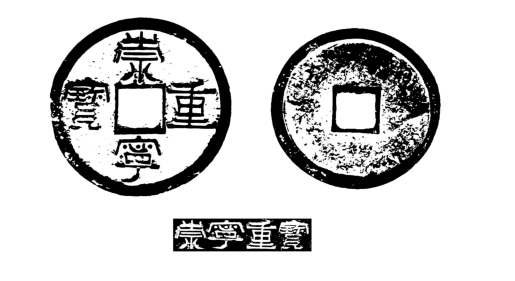

In [21]:
# 合并图片、制作拓片
image_files = glob.glob(os.path.join( './seg_pic_T/', '*.jpg'))
image_main1 = Image.open("./temp/seg_temp1.jpg")# 正面
image_main1 = image_main1.resize((1600, 1500))
image_main2 = Image.open("./temp/seg_temp2.jpg")# 背面
image_main2 = image_main2.resize((1500, 1500))
images = []
for image_file in image_files:
    image = Image.open(image_file)
    image = image.resize((250, 250))
    images.append(image)
# 合并 
new_image = Image.new("RGB", (3800, 2000), 'white') 
new_image.paste(image_main1, (200, 0))
new_image.paste(image_main2, (1900, 0))
images[3] = images[3].resize((270, 250))
images[0] = images[0].resize((320, 250))
images[2] = images[2].resize((260, 250))
images[1] = images[1].resize((260, 250))
new_image.paste(images[3], (1250, 1600))
new_image.paste(images[0], (1500, 1600))
new_image.paste(images[1], (1800, 1600))
new_image.paste(images[2], (2050, 1600))

# 保存拓片
new_image.save('./拓片2.png')

# 输出图像 
plt.axis('off')
plt.imshow(new_image)